_originally created by Marshall Perrin, edits to incorporate new code by Justin Otor_

In [ ]:
from subtract_psf import KlipRetrieve, PreInjectImages

In [ ]:
from astropy.table import Table
from astropy.visualization import ImageNormalize

import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np
import time
import astropy.io.fits as fits


# Load tables

### Original instructions from Simon Petrus:

<blockquote>

Here you can find what you need :

- The spectrum of the  star HIP65426 from the Next-Gen models. I calibrate the flux on photometric points found in VOSA. I degraded the resolution to R=10000 on the entire spectrum between 1.0 mic and 5.2 mic. I'm sorry I can't provide you a spectrum at higher wavelengths because after 5.2 mic the resolution of models decreases to few hundreds.

- The spectrum of the planet HIP65426b from the BT-SETTL15 models. This model corresponds to the best fit with data from SPHERE IFS, SPHERE LSS, SINFONI and NACO. I also calibrate the flux as an observed flux and I also degraded its resolution to R=10000 between 1.0mic and 5.2mic. 

For each spectrum the wavelengths are in microns and the fluxes are in W.m-2.mic-1</blockquote>

These units are good to move on with. If you check the help for `KlipRetrieve.inject_companion()`, it mentions that the flux column must have units of
```
erg / s / cm**2 / Hz, erg / s / cm**3, mJy, or something equivalent,
```
and the flux density units here are equivalent to the second entry of that list.

In [ ]:
# load HIP 65426A's FITS file; make it a table

#_input_star = fits.open('input_models/stellar_flux_HIP65426_10000_Next_Gen.fits')
#_input_star = fits.open('../real_spectra/stellar_flux_HIP65426_10000_Next_Gen.fits')
_input_star = fits.open('/user/jotor/gen_images/real_spectra/stellar_flux_HIP65426_10000_Next_Gen.fits')
# copy this directory to a local location like in the commented lines above for faster loading

input_star = Table([spec.data for spec in _input_star[0].data], names=['wavelength', 'flux'])

In [ ]:
# load HIP 65426b's FITS file; make it a table

#_input_planet = fits.open('input_models/planet_flux_HIP65426_10000_BT_SETTL15.fits')
#_input_planet = fits.open('../real_spectra/planet_flux_HIP65426_10000_BT_SETTL15.fits')
_input_planet = fits.open('/user/jotor/gen_images/real_spectra/planet_flux_HIP65426_10000_BT_SETTL15.fits')
# copy this directory to a local location like in the commented lines above for faster loading

input_planet = Table([spec.data for spec in _input_planet[0].data], names=['wavelength', 'flux'])

In [ ]:
# add units to each table's columns
for table in [input_planet, input_star]:
    table['wavelength'].unit = u.micron
    table['flux'].unit = u.W/ u.m**2/ u.micron

In [ ]:
# choose a wavelength range to plot
#wv_lo = 1 * u.micron
wv_lo = 2.87 * u.micron # from nirspec
wv_hi = 5.27 * u.micron # from nirspec

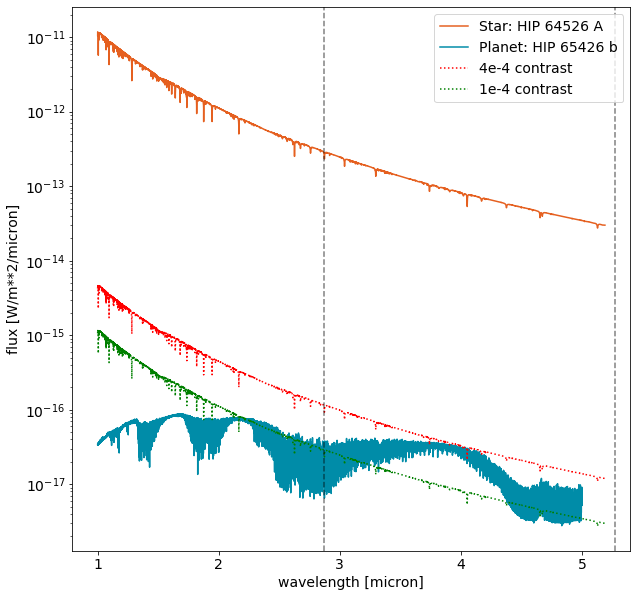

In [ ]:
# plot full spectra and a couple of contrast curves
fig, ax = plt.subplots(figsize=(10,10))
ax.semilogy(input_star['wavelength'], input_star['flux'], label='Star: HIP 64526 A', c='#e56020')
ax.semilogy(input_planet['wavelength'], input_planet['flux'], label='Planet: HIP 65426 b', c='#008ca8')
ax.semilogy(input_star['wavelength'], input_star['flux']*4e-4, label='4e-4 contrast', ls=':', c='r')
ax.semilogy(input_star['wavelength'], input_star['flux']/1e4, label='1e-4 contrast', ls=':', c='g')

# mark limits of NIRSpec's wavelength range
for wl in [wv_lo, wv_hi]:
    ax.axvline(wl.value, ls='--', color='black', alpha=0.5)

ax.set_xlabel("wavelength [micron]", fontsize=14)
ax.set_ylabel("flux [W/m**2/micron]", fontsize=14)
ax.tick_params(labelsize=14)
ax.legend(fontsize=14, loc='upper right')
#plt.savefig('hip_65426B_spectra.png', dpi=300)

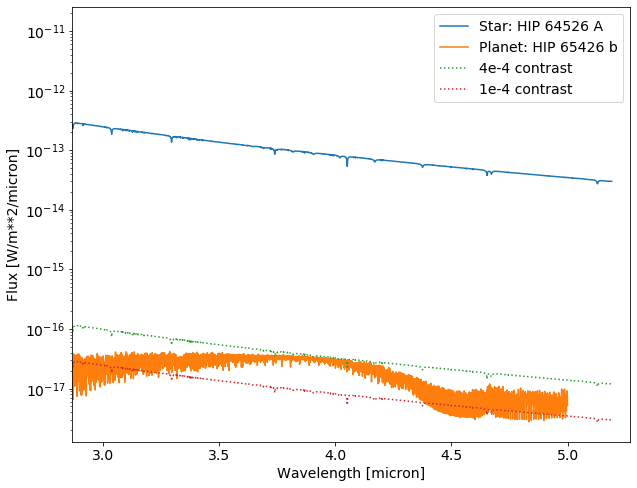

In [ ]:
# repeat the above plot, this time over NIRSpec's wavelength range only
fig, ax = plt.subplots(figsize=(10,8))
ax.semilogy(input_star['wavelength'], input_star['flux'], label='Star: HIP 64526 A')
ax.semilogy(input_planet['wavelength'], input_planet['flux'], label='Planet: HIP 65426 b')
ax.semilogy(input_star['wavelength'], input_star['flux']*4e-4, label='4e-4 contrast', ls=':')
ax.semilogy(input_star['wavelength'], input_star['flux']/1e4, label='1e-4 contrast', ls=':')

ax.set_xlim(wv_lo.value, wv_hi.value)
ax.set_xlabel("Wavelength [micron]", fontsize=14)
ax.set_ylabel("Flux [W/m**2/micron]", fontsize=14)
ax.tick_params(labelsize=14)
ax.legend(fontsize=14, loc='upper right')

# Pre-inject a set of simulated data cubes.

In this section, we use the edited spectra from above (`input_star` and `input_planet`) to inject a synthetic companion into the target images of all data cubes in an already existing directory of "observations" generated by `CreateImages()`. The "pre" refers to the fact that this will happen before any of the alignment or subtraction steps shown in [introduction.ipynb](introduction.ipynb).

`subtract_psf` has a special class for this process called `PreInjectImages()`. We'll try it on a full, 3610 slice set of data cubes to give an idea of how a real application of the class looks. See the corresponding cells in [`inject_kappa_and.ipynb`](inject_kappa_and.ipynb) for an idea of how long the cells will take to run.

*(if you've imported `subtract_psf` and are curious about any of the methods mentioned, put your cursor on it and press `Shift`+`Tab` a couple of times to view the docstrings.)*

In [ ]:
sep_arcsec = 0.8 * u.arcsec

In [ ]:
#injector = PreInjectImages('/Users/mperrin/data/ifu_sims/_all_slices_4_os0')
#injector = PreInjectImages('/Users/jotor/gen_images_copy/_all_slices_4_os0/')
injector = PreInjectImages('/user/jotor/gen_images/_all_slices_4_os0/')
# copy this directory to a local location like in the commented lines above for faster loading

In [ ]:
cubes_with_comp = injector.inject_companion(injector.data_cubes,
                                            star_spectrum=input_star,
                                            comp_spectrum=input_planet,
                                            separation=sep_arcsec.value,
                                            position_angle=150) 

********
injecting companion with spectrally defined intensity into unaligned images.
********


In [ ]:
header = cubes_with_comp[0].header # index doesn't matter
cont_headers = [h for h in header if h.startswith('CONT')]
injected_companion_contrast_spectrum = np.array([header[cont] for cont in cont_headers])

injected_companion_contrast_spectrum[:20], injected_companion_contrast_spectrum.shape

(array([7.59549950e-05, 8.94359699e-05, 5.28390629e-05, 7.13212817e-05,
        4.43164277e-05, 5.39715176e-05, 6.90806591e-05, 8.39996055e-05,
        9.68643864e-05, 1.30952689e-04, 1.12061930e-04, 7.86272773e-05,
        6.18583794e-05, 8.58029898e-05, 7.99953395e-05, 8.55730381e-05,
        7.50925306e-05, 6.09614856e-05, 9.40740178e-05, 7.56346414e-05]),
 (3610,))

We can then export an HDUList that includes these injected cubes (`pre_full0.injected_cubes`) to a new directory, remembering to include the uninjected reference cubes from `pre_full0.data_cubes` as its first half.

In [ ]:
all_cubes = injector.data_cubes[:len(injector.positions)] + cubes_with_comp

fits.HDUList(all_cubes).info()

Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  REFERENCE0    1 ImageHDU      3721   (30, 30, 3610)   float64   
  1  REFERENCE1    1 ImageHDU      3721   (30, 30, 3610)   float64   
  2  REFERENCE2    1 ImageHDU      3721   (30, 30, 3610)   float64   
  3  REFERENCE3    1 ImageHDU      3721   (30, 30, 3610)   float64   
  4  REFERENCE4    1 ImageHDU      3721   (30, 30, 3610)   float64   
  5  REFERENCE5    1 ImageHDU      3721   (30, 30, 3610)   float64   
  6  REFERENCE6    1 ImageHDU      3721   (30, 30, 3610)   float64   
  7  REFERENCE7    1 ImageHDU      3721   (30, 30, 3610)   float64   
  8  REFERENCE8    1 ImageHDU      3721   (30, 30, 3610)   float64   
  9  REFERENCE9    1 ImageHDU      3721   (30, 30, 3610)   float64   
 10  TARGET0       1 ImageHDU      7335   (30, 30, 3610)   float64   
 11  TARGET1       1 ImageHDU      7335   (30, 30, 3610)   float64   
 12  TARGET2       1 ImageHDU      7335   (30, 30

In [ ]:
injector.export_to_new_dir(all_cubes, 'test_hip65426')

# Subtract the background star from the injected data cubes.

Next, we use the `KlipRetrieve` class from `subtract_psf` on this new directory of injected images. Once initialized, it performs a few steps to subtract the background star from the target images.

- It aligns all data cube images (both reference and target) so the star is in nearly the same spot in all of them.
- Next, it makes KLIP projections of the target images by using the reference images to calculate a PCA basis.
- Then, it subtracts each projection by its corresponding target image, hopefully leaving a set of data cubes with only the companion in each slice.

_(Note that the star is scaled to have the same brightness in all slices, so the companion's brightness is influenced by changes in both its own flux *and* the star's.)_

In [ ]:
subtractor = KlipRetrieve('test_hip65426/')

in test_hip65426/...
********
aligning all data cubes' images by their bright pixels...
********
********
removing padding from alignment process...
********
********
generating KLIP projections of target images in `self.klip_proj`...
********
********
generating pre-/post-subtraction contrast curves...
********
********
completed `self.pre_prof_hdu`, `self.post_prof_hdu`, `self.photon_prof_hdu`, and `self.pre_avg_hdu`.
********



********
total intensity pre-subtract:  9.4749e-01
total intensity post-subtract: 1.0179e-02
********


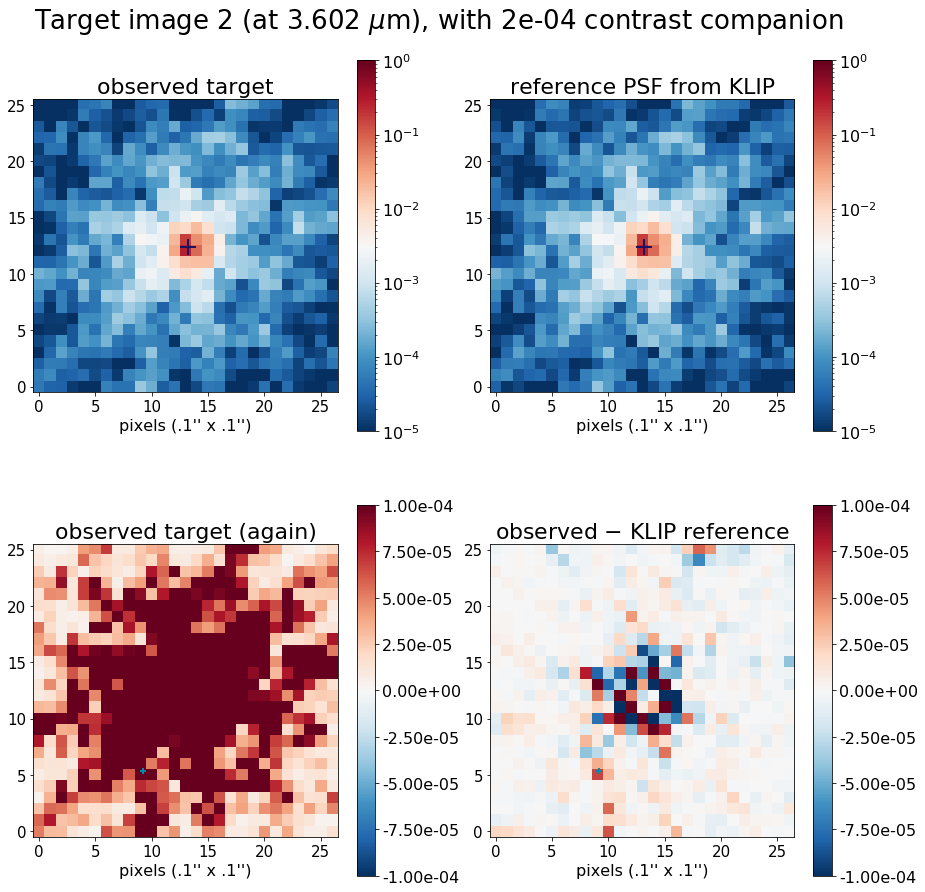

(0.9474914949010574, 0.01017887096176844)

In [ ]:
# examine pre and post-subtraction versions of one slice of one injected image
subtractor.plot_subtraction(target_image=2, wv_slice=1100, companion=True,
                            cmap=plt.cm.RdBu_r,
                            norm=ImageNormalize(vmin=-1e-4, vmax=1e-4))


********
1 arcsecond contrast @2.87 microns
pre-sub:  1.3526e-03 | post-sub: 8.3031e-05
********

********
1 arcsecond contrast @4.07 microns
pre-sub:  1.9158e-03 | post-sub: 1.5051e-04
********

********
1 arcsecond contrast @5.27 microns
pre-sub:  2.6468e-03 | post-sub: 1.1766e-04
********


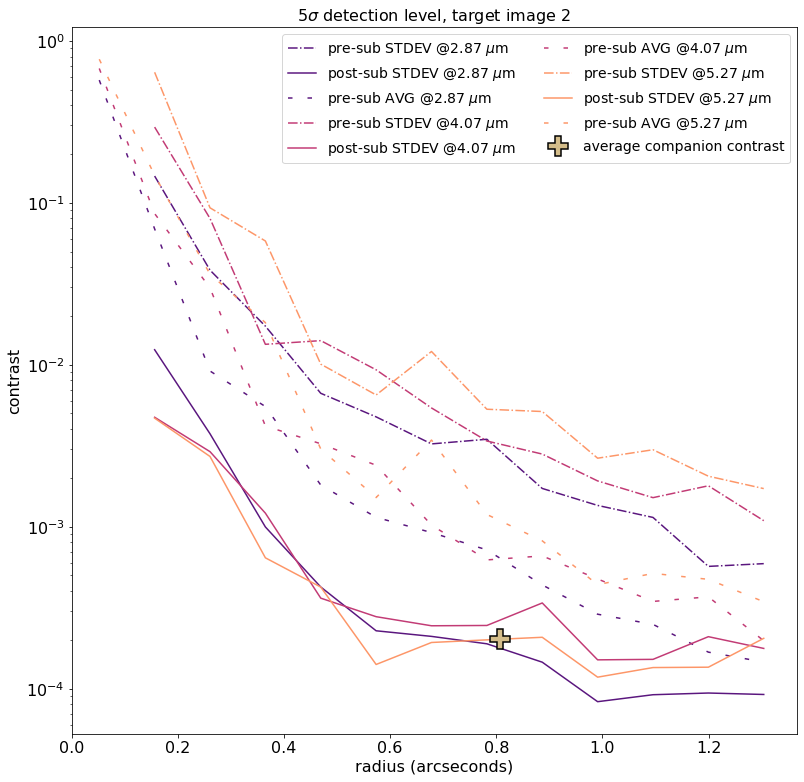

In [ ]:
subtractor.plot_contrasts(target_image=2, times_sigma=5, companion=True)

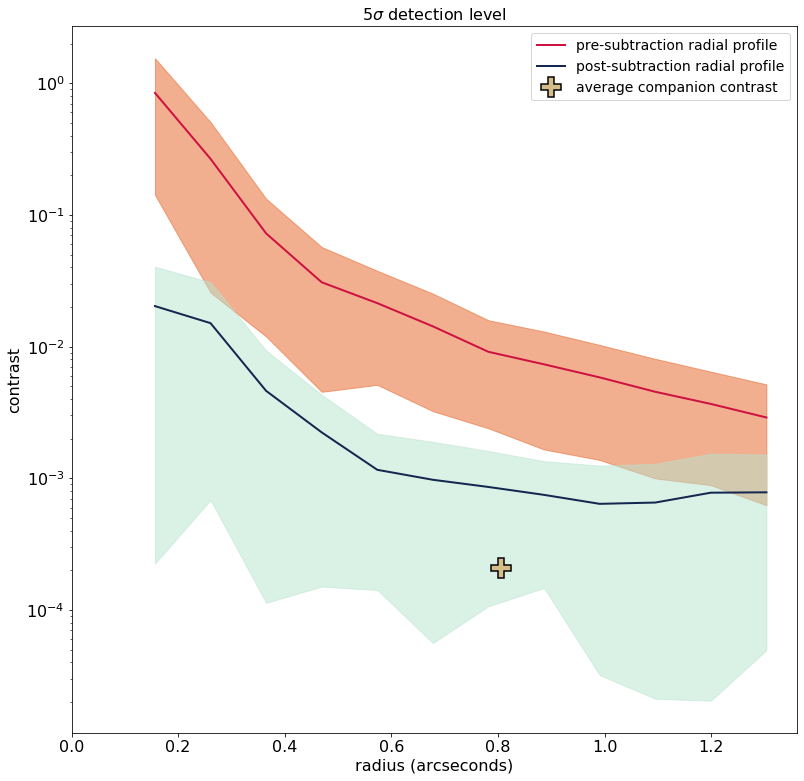

In [ ]:
subtractor.plot_contrasts_avg(times_sigma=5, companion=True)

# Export the subtracted data cubes to their own directory.

Once that's through, you're one function call away from exporting your results.

In [ ]:
subtractor.export_subtracted_cubes('subtracted_hip65426')

# Extension: Use subtracted cubes to plot post-subtraction companion spectra.

You can find the subtracted cubes in `KlipRetrieve.subtracted_cubes`.

In [ ]:
subtractor.subtracted_cubes.info()

Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  REFERENCE0    1 ImageHDU      3721   (27, 26, 3610)   float64   
  1  REFERENCE1    1 ImageHDU      3721   (27, 26, 3610)   float64   
  2  REFERENCE2    1 ImageHDU      3721   (27, 26, 3610)   float64   
  3  REFERENCE3    1 ImageHDU      3721   (27, 26, 3610)   float64   
  4  REFERENCE4    1 ImageHDU      3721   (27, 26, 3610)   float64   
  5  REFERENCE5    1 ImageHDU      3721   (27, 26, 3610)   float64   
  6  REFERENCE6    1 ImageHDU      3721   (27, 26, 3610)   float64   
  7  REFERENCE7    1 ImageHDU      3721   (27, 26, 3610)   float64   
  8  REFERENCE8    1 ImageHDU      3721   (27, 26, 3610)   float64   
  9  REFERENCE9    1 ImageHDU      3721   (27, 26, 3610)   float64   
 10  TARGET0       1 ImageHDU      7335   (27, 26, 3610)   float64   
 11  TARGET1       1 ImageHDU      7335   (27, 26, 3610)   float64   
 12  TARGET2       1 ImageHDU      7335   (27, 26

In [ ]:
import warnings

In [ ]:
def show_extracted_spectrum(subtracted, imagenum=0, slice=1100):
    
    imagenum += len(subtractor.positions) # make sure you're using a target cube

    fig, axes = plt.subplots(figsize=(10,4), ncols=2,
                             gridspec_kw={'width_ratios': [1, 1.5], 'wspace': 0.4})
    
    axes[0].imshow(subtracted[imagenum].data[slice], vmin=-1e-4, vmax=1e-4,
                   cmap=plt.cm.RdBu_r, origin='lower')
    
    #px, py = 8,7
    py = int(subtracted[imagenum].header['PIXSTARY']
             + subtracted[imagenum].header['PIXCOMPY'])
    px = int(subtracted[imagenum].header['PIXSTARX']
             + subtracted[imagenum].header['PIXCOMPX'])
    
    axes[0].scatter([px],[py], marker='o', edgecolors='red', facecolors='none', s=500)
    axes[0].set_xlabel("Pixels")
    axes[0].set_title(f"Subtracted image at {subtractor.wvlnths[slice]*1e6:.2f} microns"
                      f"\nDither position {imagenum % len(subtractor.positions)}")

    # unsure if you intended to use absolute value of y for subtracted values here?
    axes[1].semilogy(subtractor.wvlnths*1e6,
                     np.abs(subtracted[imagenum].data[:, py, px]),
                     c='navy', label='Contrast in peak pixel')
    axes[1].semilogy(subtractor.wvlnths*1e6,
                     np.abs(subtracted[imagenum].data[:, py-1:py+2, px-1:px+2].sum(axis=2).sum(axis=1)),
                     color='red', label='Contrast in 3x3 aperture')

    try:
        axes[1].semilogy(injector.wvlnths*1e6, injected_companion_contrast_spectrum, 
                        ls='--', label='Injected companion contrast spectrum',
                         c='darkorange')
        # (injector.wvlnths and subtractor.wvlnths will be equal
        #  since they both derive from _all_slices_4_os0)
    except:
        warnings.warn('Could not plot injected companion contrast spectrum')

    axes[1].set_xlabel("Wavelength [micron]")
    axes[1].set_ylabel("Contrast")
    axes[1].set_ylim(1e-8, 1e-3)

    axes[1].legend()

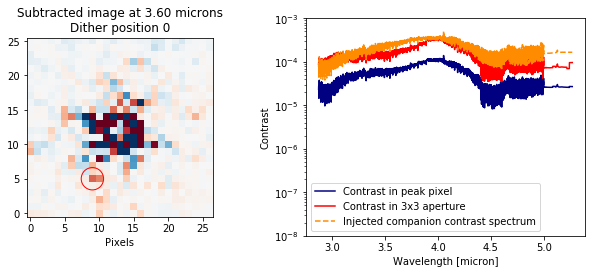

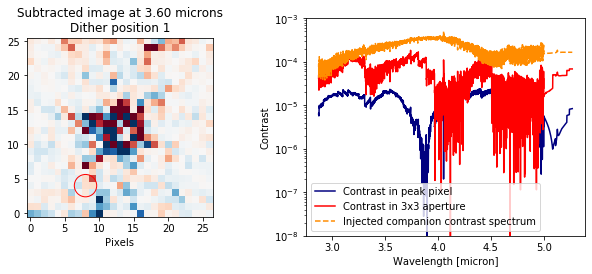

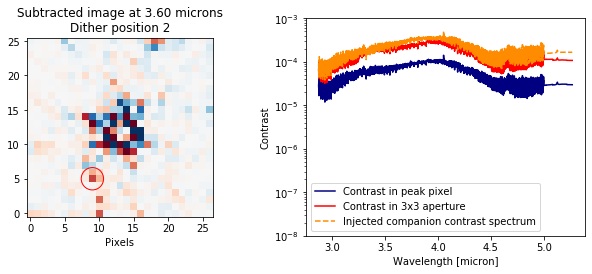

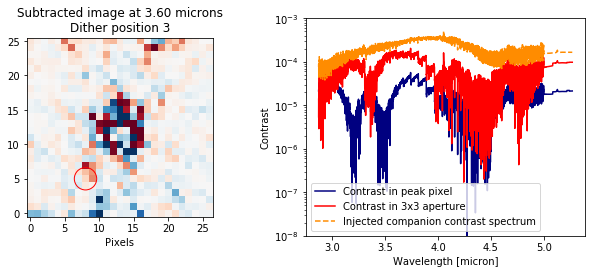

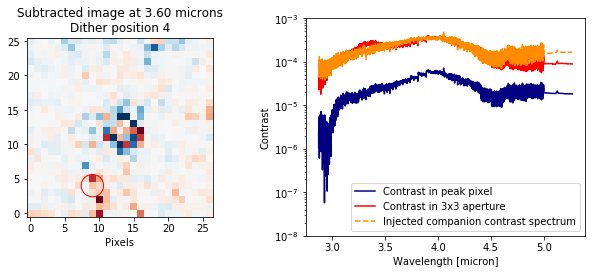

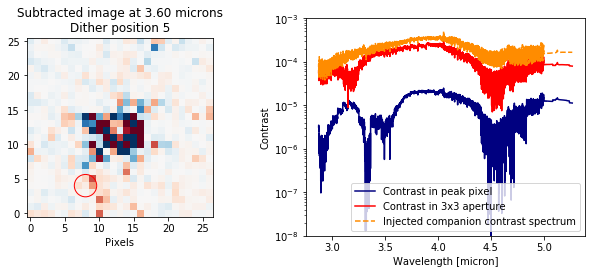

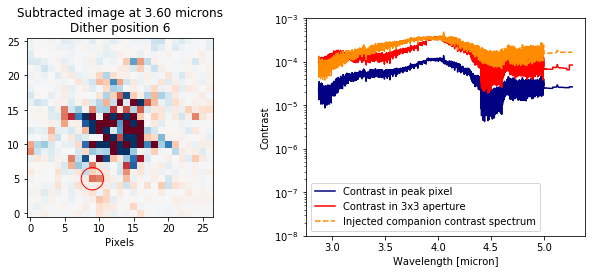

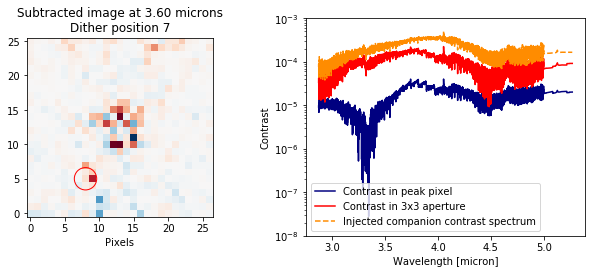

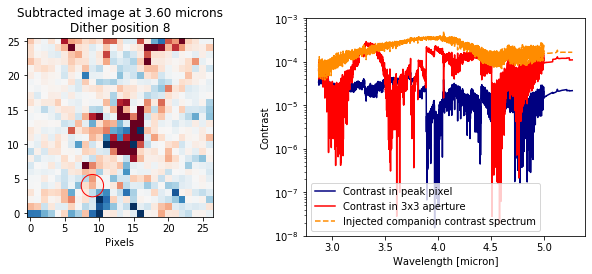

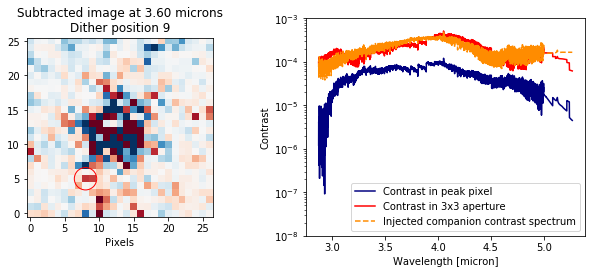

In [ ]:
for i in range(len(subtractor.positions)):
    show_extracted_spectrum(subtractor.subtracted_cubes, i)

#show_extracted_spectrum(subtractor.subtracted_cubes, i)

______

/Users/mperrin/software/miniconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:24: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


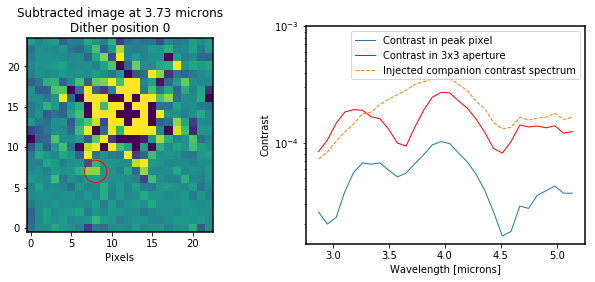

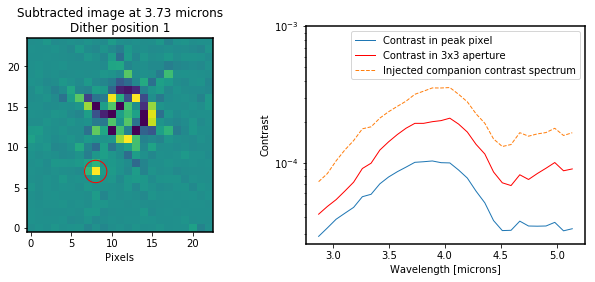

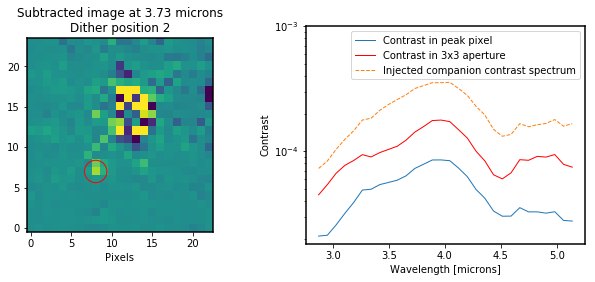

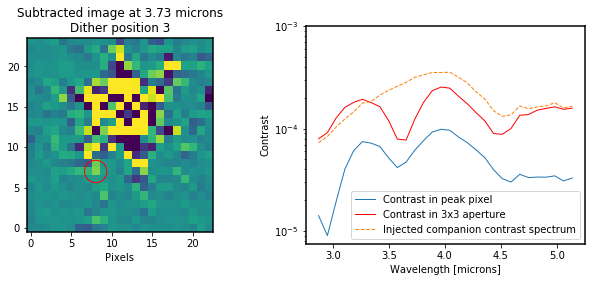

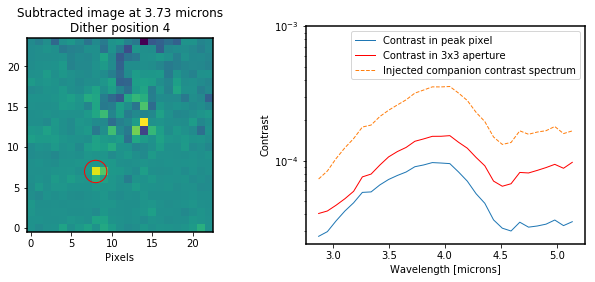

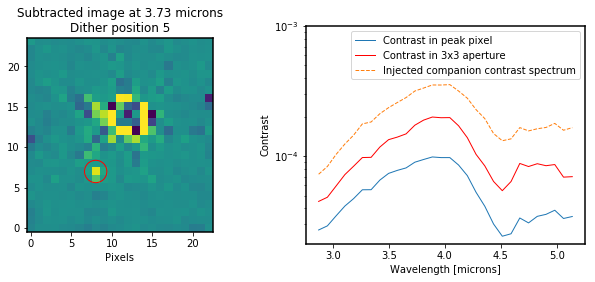

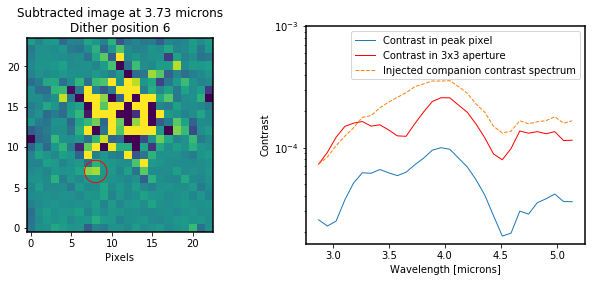

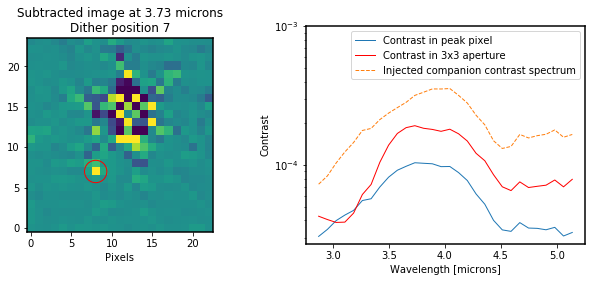

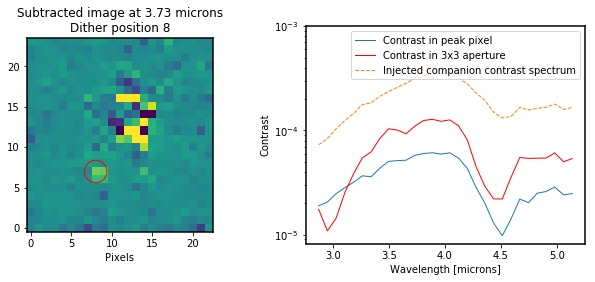

In [ ]:
# old version of show_extracted_spectrum()

# threw warnings because y axis is of rightmost plot is logarithmic and log(0) in original ylim is undefined

# also had a small mix-up in slicing the 3x3 sum array
# [:,py-1:py+2,px-1:py+2] instead of. [:, py-1:py+2, px-1:px+2]
for i in range(len(subtractor.positions)):
    show_extracted_spectrum(subtractor.subtracted_cubes, i)